In [379]:
import pandas as pd # type: ignore
from datetime import datetime # type: ignore
import numpy as np #type: ignore
from sklearn.metrics import mean_squared_error # type: ignore

In [380]:
import glob

folder_path = 'LJP'

# Get a list of all CSV files in the folder
csv_files = glob.glob(folder_path + '/*.csv')

# Create an empty list to store the DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
	df = pd.read_csv(file)
	dfs.append(df)

# Concatenate all the DataFrames together
df_arso = pd.concat(dfs, ignore_index=True)
df_arso.head()

,station id,station name,valid,T [°C],količina padavin [mm],globalno sev. [W/m2]
0,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:00,-2.6,0.0,0.0
1,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:10,-2.6,NaN,NaN
2,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:20,-2.6,NaN,NaN
3,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:30,-3.4,0.0,0.0
4,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:40,-2.9,NaN,NaN


In [381]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df_arso):
	# Filter rows based on column: ' valid'
	df_arso = df_arso[df_arso[' valid'].str.endswith("00", na=False)]
	# Drop columns: 'station id', ' station name'
	df_arso = df_arso.drop(columns=['station id', ' station name'])
	# Change column type to datetime64[ns] for column: ' valid'
	df_arso = df_arso.astype({' valid': 'datetime64[ns]'})
	# Rename column ' valid' to 'datum'
	df_arso = df_arso.rename(columns={' valid': 'datum'})
	return df_arso

df_arso_clean = clean_data(df_arso.copy())
df_arso_clean.head()

,datum,T [°C],količina padavin [mm],globalno sev. [W/m2]
0,2022-01-01 00:00:00,-2.6,0.0,0.0
6,2022-01-01 01:00:00,-3.2,0.0,0.0
12,2022-01-01 02:00:00,-3.9,0.0,0.0
18,2022-01-01 03:00:00,-2.8,0.0,0.0
24,2022-01-01 04:00:00,-3.1,0.0,0.0


In [382]:
df_eles = pd.read_csv('ELES.csv', sep=';')

"""
Cell generated by Data Wrangler.
"""
from datetime import datetime

def clean_data(df_eles):
    df_eles['datum'] = pd.to_datetime(df_eles['datum'], dayfirst=True)
    df_eles['ura'] = df_eles['ura'].str[1:3].astype(int) - 1
    df_eles['datum'] = df_eles['datum'] + pd.to_timedelta(df_eles['ura'], unit='h')
    df_eles.drop(columns=['ura', 'predvidena_proizvodnja', 'dejanska_proizvodnja', 'nek', 'termo', 'hidro', 'predviden_prevzem'], inplace=True)
    # Filter rows based on column: 'datum'
    # df_eles = df_eles[df_eles['datum'] >= datetime.strptime('2024-08-01T00:00:00.000Z', '%Y-%m-%dT%H:%M:%S.%fZ')]
    return df_eles

df_eles_clean = clean_data(df_eles.copy())
df_eles_clean.head()

,datum,dejanski_prevzem
0,2022-01-01 00:00:00,1044.0
1,2022-01-01 01:00:00,1018.0
2,2022-01-01 02:00:00,975.0
3,2022-01-01 03:00:00,944.0
4,2022-01-01 04:00:00,936.0


In [383]:
df_pokritost = pd.read_csv('LJP_pokritost_2022-2024.csv')
df_pokritost['datum'] = pd.to_datetime(df_pokritost[' valid'])
df_pokritost = df_pokritost.drop(columns=['station id', ' station name', ' valid'])
df_pokritost.head()

,oblačnost [%],datum
0,37.0,2022-01-01
1,40.0,2022-01-02
2,80.0,2022-01-03
3,100.0,2022-01-04
4,100.0,2022-01-05


In [384]:
df_prazniki = pd.read_csv('prazniki.csv', header=None)
df_prazniki['datum'] = pd.to_datetime(df_prazniki[0])
df_prazniki = df_prazniki.drop(columns=[0])
df_prazniki = df_prazniki.rename(columns={1: 'holiday'})

# Generate a new DataFrame with all dates between 2022-01-01 and 2024-10-23
df_all_dates = pd.DataFrame({'datum': pd.date_range('2022-01-01', '2024-10-23')})

# Merge the new DataFrame with df_prazniki, filling in missing values with 0
df_prazniki = pd.merge(df_all_dates, df_prazniki, on='datum', how='left').fillna(0)

df_prazniki.head()

,datum,holiday
0,2022-01-01,1.0
1,2022-01-02,1.0
2,2022-01-03,0.0
3,2022-01-04,0.0
4,2022-01-05,0.0


In [385]:
df1 = pd.merge(df_eles_clean, df_arso_clean, on='datum')
df2 = pd.merge(df1, df_pokritost, on='datum', how='outer')
df = pd.merge(df2, df_prazniki, on='datum', how='outer')
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Drop duplicate rows in column: 'datum'
    df = df.drop_duplicates(subset=['datum'])
    # Renames
    df = df.rename(columns={'datum': 'date', 
                            'dejanski_prevzem': 'consumption',
                            'T [°C]': 'temperature',
                            'količina padavin [mm]': 'precipitation',
                            'globalno sev. [W/m2]': 'irradiation',
                            'oblačnost [%]': 'cloudiness'
                        })
    df.ffill(inplace=True)
    df = df[(df['date'].dt.day != 29) | (df['date'].dt.month != 2)]
    df = df.drop(df.index[0])
    return df

df = clean_data(df.copy())
df.head()

,date,consumption,temperature,precipitation,irradiation,cloudiness,holiday
1,2022-01-01 01:00:00,1018.0,-3.2,0.0,0.0,37.0,1.0
2,2022-01-01 02:00:00,975.0,-3.9,0.0,0.0,37.0,1.0
3,2022-01-01 03:00:00,944.0,-2.8,0.0,0.0,37.0,1.0
4,2022-01-01 04:00:00,936.0,-3.1,0.0,0.0,37.0,1.0
5,2022-01-01 05:00:00,952.0,-4.1,0.0,0.0,37.0,1.0


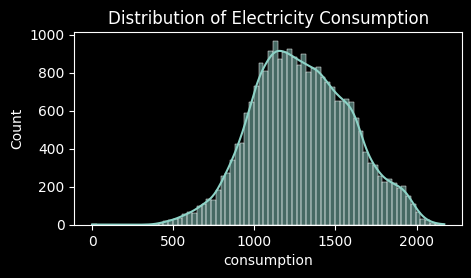

In [386]:
# Import libraries for visualization
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

# Plot histogram for electricity consumption
plt.figure(figsize=(5, 2.5))
sns.histplot(df['consumption'], kde=True)
# sns.histplot(df['T [°C]'], kde=True)
plt.title('Distribution of Electricity Consumption')
plt.show()

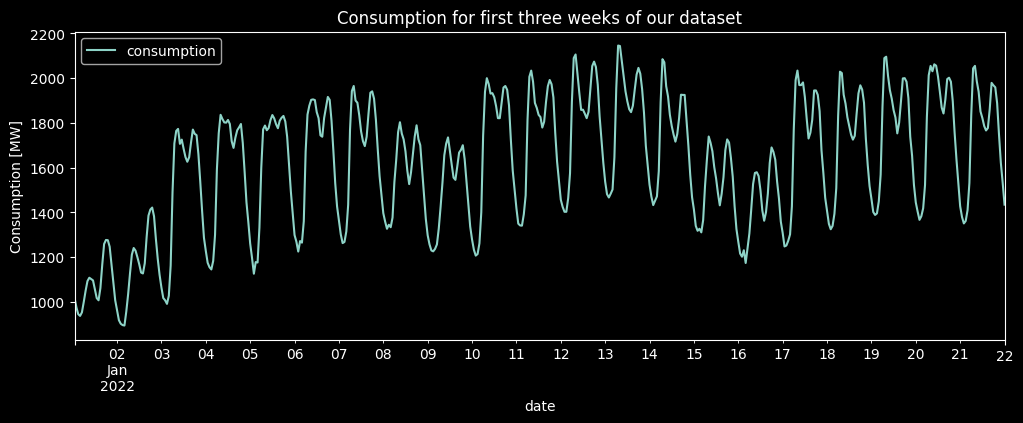

In [387]:
#How does timeseries look like for first three weeks of year 2023
df.head(168*3).plot(x = 'date',
					y = 'consumption',
					title = 'Consumption for first three weeks of our dataset',
					figsize =(12,4)
				)
plt.ylabel('Consumption [MW]')

# Show the plot
plt.show()

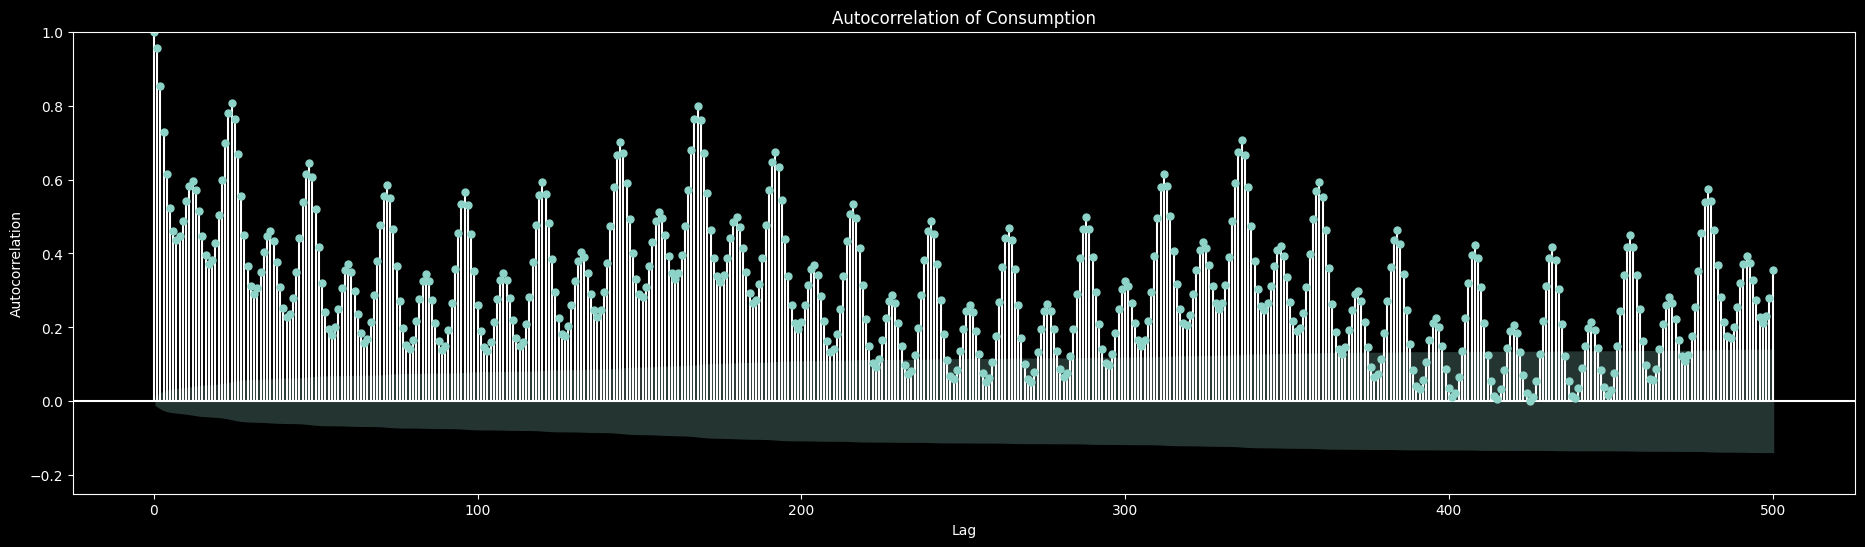

In [388]:
#autocorellation
from statsmodels.graphics.tsaplots import plot_acf # type: ignore

# Set figure size to make it wider
fig = plt.figure(figsize=(23, 6))  # Adjust the width as needed
ax = fig.add_subplot(111)

# Plot autocorrelation for the 'Consumption' column with 400 lags
plot_acf(df.ffill()['consumption'], lags=500,ax=ax)
plt.title('Autocorrelation of Consumption')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(-0.25, 1)
plt.show()

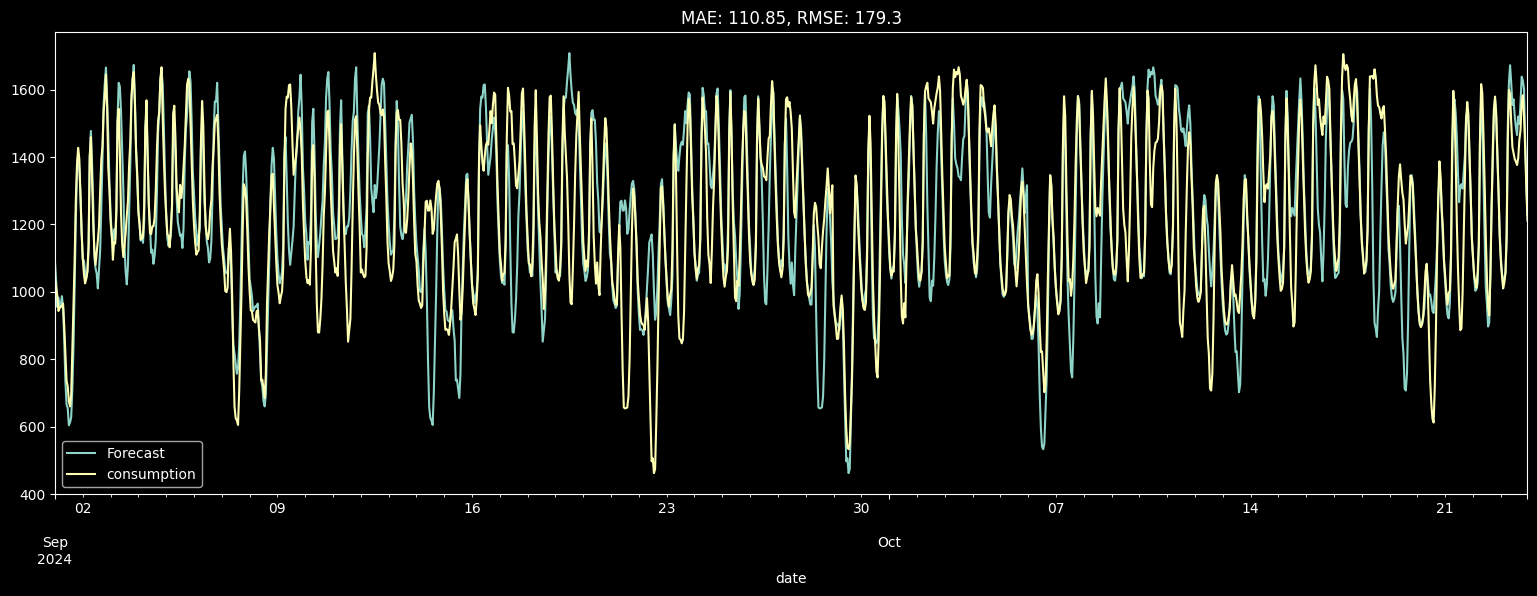

In [389]:
df_hourly = df.set_index('date')
df_hourly = df_hourly.asfreq('h')
df_hourly.ffill(inplace=True)

#in porduciton we can not use 24 hour lag for all products, so we use 168 lag (1 week)
df_hourly['ShiftedConsumption_168'] = df_hourly['consumption'].shift(168)

cutoff_date = '2024-09-01 00:00:00'

# simplest model -> forecast for next day is same as it was last week for the same day
y_test =  df_hourly.loc[cutoff_date:,'consumption']
forecast = df_hourly.loc[cutoff_date:, 'ShiftedConsumption_168']

forecast.name = 'Forecast'
rmse = round(np.sqrt(mean_squared_error(y_test, forecast)), 2)
mae = round((forecast - y_test).abs().mean(), 2)

plt_title = 'MAE: '+str(mae) + ', RMSE: '+str(rmse)

forecast.plot(title=plt_title, figsize=(19, 6), legend=True)
ax = y_test.plot(title=plt_title, figsize=(19, 6), legend=True)
#mape = (test_data['Consumption'] - test_data['ShiftedConsumption']).abs() / test_data['Consumption']y

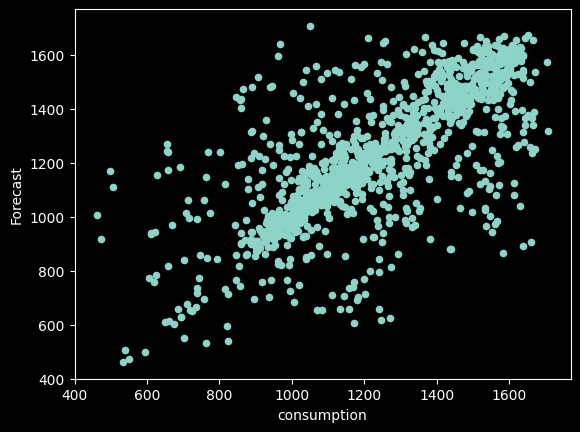

In [390]:
ax = pd.concat((y_test, forecast), axis=1).plot(x='consumption', y='Forecast', kind='scatter')

In [391]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore

df_hourly = df.copy()
df_hourly['shifted_consumption_168'] = df['consumption'].shift(168)

# Split the dataset based on the cutoff date
cutoff_date = '2024-09-01 00:00:00'
train_data = df_hourly[df_hourly['date'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['date'] >= cutoff_date]



X_train = train_data[['shifted_consumption_168']]
X_test = test_data[['shifted_consumption_168']]
y_train = train_data['consumption']
y_test = test_data['consumption']


reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
forecast = pd.Series(reg.predict(X_test), index=X_test.index, name='Forecast')

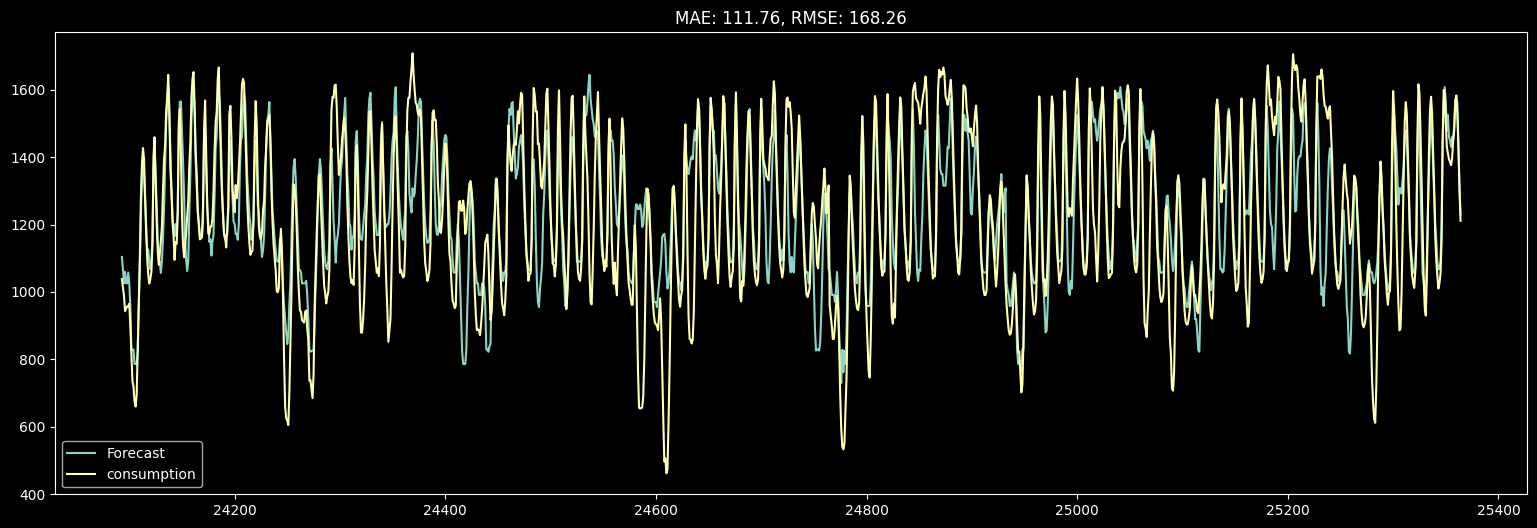

In [392]:
rmse = round(np.sqrt(mean_squared_error(y_test, forecast)), 2)
mae = round((forecast - y_test).abs().mean(), 2)

plt_title = 'MAE: '+str(mae) + ', RMSE: '+str(rmse)

forecast.plot(title=plt_title, figsize=(19, 6), legend=True)
ax = y_test.plot(title=plt_title, figsize=(19, 6), legend=True)

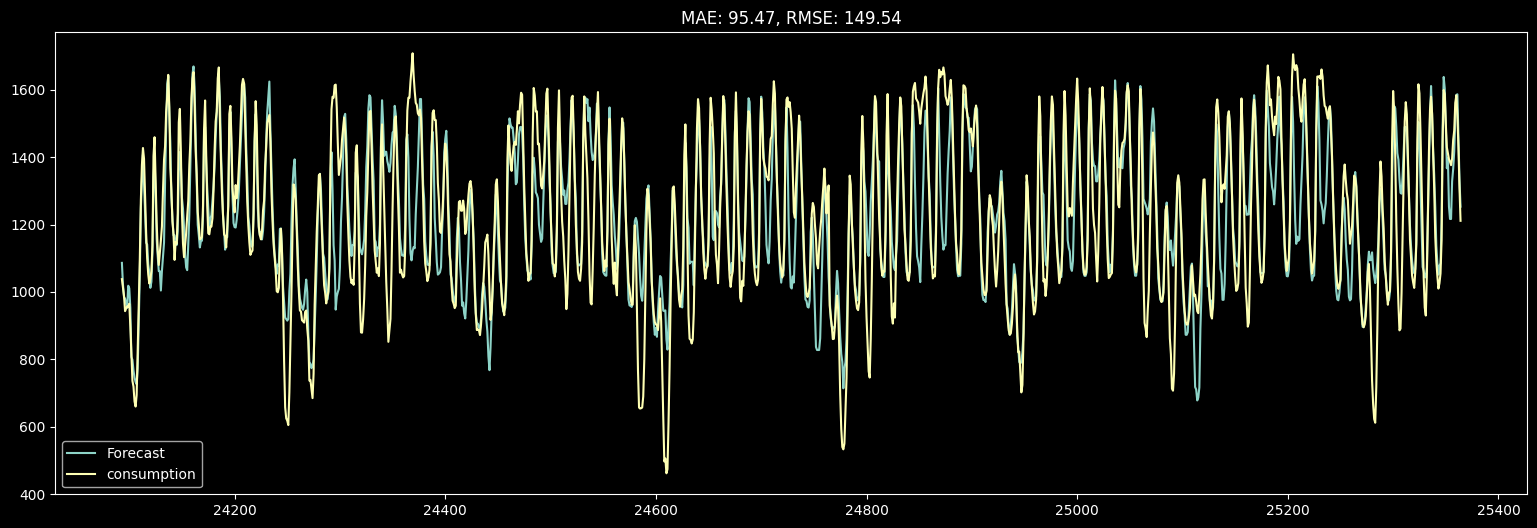

In [393]:
df_hourly['shifted_consumption_48'] = df_hourly['consumption'].shift(48)
df_hourly['hour'] = df_hourly['date'].dt.hour
df_hourly['weekDay'] = df_hourly['date'].dt.weekday

cutoff_date = '2024-09-01 00:00:00'
train_data = df_hourly[df_hourly['date'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['date'] >= cutoff_date]

X_train = train_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48']]
X_test = test_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48']]
y_train = train_data['consumption']
y_test = test_data['consumption']


reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
forecast = pd.Series(reg.predict(X_test), index=X_test.index, name='Forecast')

rmse = round(np.sqrt(mean_squared_error(y_test, forecast)), 2)
mae = round((forecast - y_test).abs().mean(), 2)

plt_title = 'MAE: '+str(mae) + ', RMSE: '+str(rmse)

forecast.plot(title=plt_title, figsize=(19, 6), legend=True)
ax = y_test.plot(title=plt_title, figsize=(19, 6), legend=True)

# Moja koda od tu naprej

Dodamo vse ostale stvari v model za train

In [394]:
df_hourly.head()

,date,consumption,temperature,precipitation,irradiation,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,hour,weekDay
1,2022-01-01 01:00:00,1018.0,-3.2,0.0,0.0,37.0,1.0,NaN,NaN,1,5
2,2022-01-01 02:00:00,975.0,-3.9,0.0,0.0,37.0,1.0,NaN,NaN,2,5
3,2022-01-01 03:00:00,944.0,-2.8,0.0,0.0,37.0,1.0,NaN,NaN,3,5
4,2022-01-01 04:00:00,936.0,-3.1,0.0,0.0,37.0,1.0,NaN,NaN,4,5
5,2022-01-01 05:00:00,952.0,-4.1,0.0,0.0,37.0,1.0,NaN,NaN,5,5


In [422]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore
from sklearn.naive_bayes import GaussianNB # type: ignore
from sklearn import neighbors # type: ignore
from sklearn import linear_model # type: ignore
from sklearn import svm # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore

df_hourly = df.copy()
df_hourly['shifted_consumption_168'] = df_hourly['consumption'].shift(168)
df_hourly['shifted_consumption_48'] = df_hourly['consumption'].shift(48)
df_hourly['shifted_consumption_8760'] = df_hourly['consumption'].shift(8760)
df_hourly['hour'] = df_hourly['date'].dt.hour
df_hourly['weekDay'] = df_hourly['date'].dt.weekday

# Split the dataset based on the cutoff date
cutoff_date = '2024-09-01 00:00:00'
train_data = df_hourly[df_hourly['date'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['date'] >= cutoff_date]

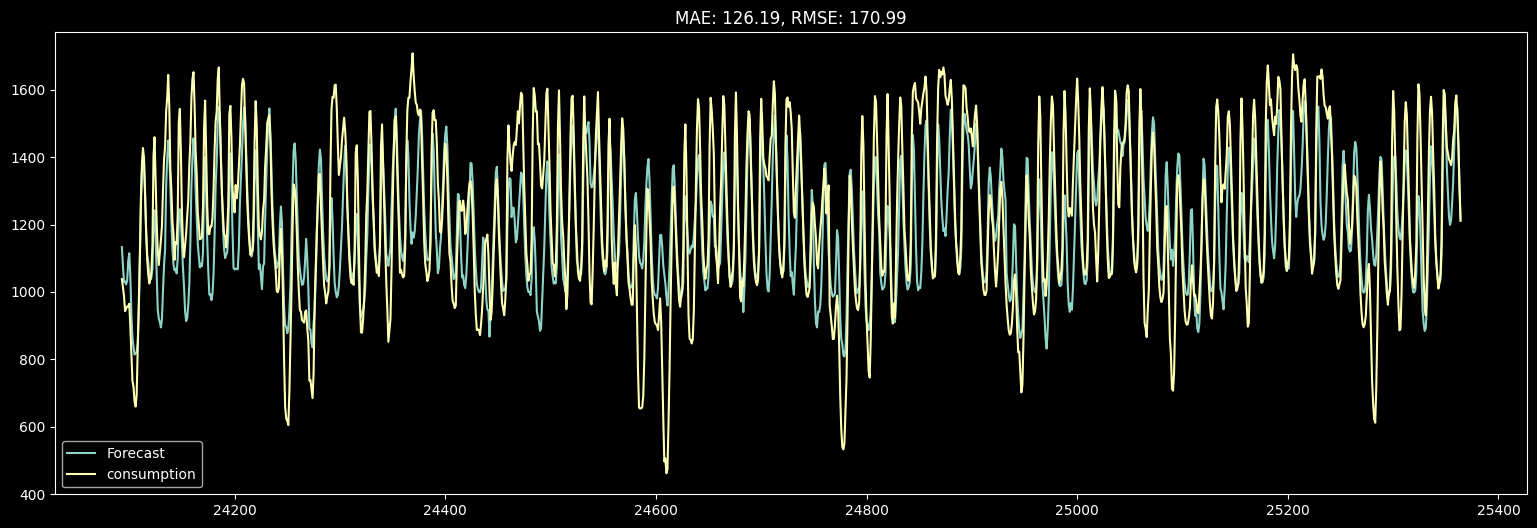

In [423]:
X_train = train_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48', 'temperature', 'cloudiness', 'holiday', 'precipitation', 'irradiation', 'shifted_consumption_8760']]
X_test = test_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48', 'temperature', 'cloudiness', 'holiday', 'precipitation', 'irradiation', 'shifted_consumption_8760']]
y_train = train_data['consumption']
y_test = test_data['consumption']

# reg = linear_model.Lasso(alpha=0.1)
# reg = linear_model.Ridge(alpha=.5)
# reg = svm.SVR()
clf = RandomForestClassifier(n_estimators=10)
reg.fit(X_train, y_train)
forecast = pd.Series(reg.predict(X_test), index=X_test.index, name='Forecast')

rmse = round(np.sqrt(mean_squared_error(y_test, forecast)), 2)
mae = round((forecast - y_test).abs().mean(), 2)

plt_title = 'MAE: '+str(mae) + ', RMSE: '+str(rmse)

forecast.plot(title=plt_title, figsize=(19, 6), legend=True)
ax = y_test.plot(title=plt_title,figsize=(19, 6), legend=True)

### Results
| Thingy							| MAE		| RMSE		|
| ---								| ---		| ---		|
| Added all 9 vars               	| 75.66 	| 113.97	|
| Added yearly shift				| 78.79		| 111.67	|
| KNN								| 130.33    | 185.37	|
| Lasso								| 111.22    | 150.37	|

# Future forecast

In [349]:
from datetime import datetime, timedelta
today_midnight = datetime.combine(datetime.today(), datetime.min.time())
cutoff_date=today_midnight + timedelta(days=1)
end_date=today_midnight + timedelta(days=2)

cutoff_date = '2024-10-23 00:00:00'
train_data = df_hourly[df_hourly['date'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['date'] >= cutoff_date]

X_train = train_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48', 'temperature', 'cloudiness', 'holiday', 'precipitation', 'irradiation']]
X_test = test_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48', 'temperature', 'cloudiness', 'holiday', 'precipitation', 'irradiation']]
y_train = train_data['consumption']
y_test = test_data['consumption']

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

result = test_data.copy()
result['forecast'] = pd.Series(reg.predict(X_test), index = X_test.index, name='Forecast')

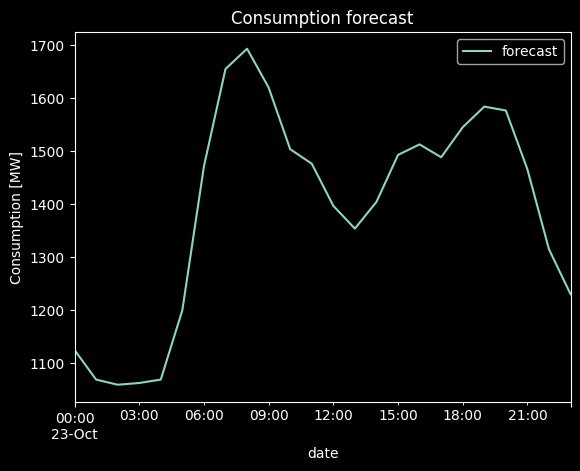

In [350]:
#View how does forecast look like
result.plot(title='Consumption forecast',y='forecast',x='date')
plt.ylabel('Consumption [MW]')
plt.show()

In [351]:
#Change DateTime format
result=result[['date','forecast']].copy()
result['date'] = result['date'].dt.strftime('%Y-%m-%dT%H:%M:%S')

In [352]:
#Save to csv without header
result.to_csv('output_file.csv', index=False, header=False,sep=',')
result

,date,forecast
25341,2024-10-23T00:00:00,1124.592182
25342,2024-10-23T01:00:00,1068.847320
25343,2024-10-23T02:00:00,1059.146352
25344,2024-10-23T03:00:00,1062.428124
25345,2024-10-23T04:00:00,1068.847320
25346,2024-10-23T05:00:00,1199.600679
25347,2024-10-23T06:00:00,1470.562002
25348,2024-10-23T07:00:00,1654.122024
25349,2024-10-23T08:00:00,1692.341185
25350,2024-10-23T09:00:00,1619.279688
